In [1]:
%%capture
#### Load Libraries (without cell output)

import autograd.numpy as np # import autograd wrapped numpy
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import neighbors, metrics
from sklearn.preprocessing import scale

import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Gamma

In [2]:
claims = pd.read_csv("./Qualification_Package/Claims_Years_1_to_3.csv")
print(claims['claim_amount'].mean())

print(claims.shape)

1187.758451280604
(14173, 24)


In [3]:
from solution_library import *

x, y = claims_preprocess_get_xy()
x_train, x_test, y_train, y_test = preprocess_xy(claims)

c:\Users\kyle\OneDrive\Programs\Cooperators_2024\solution_library.py:33: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  claims['pol_pay_freq'] = claims['pol_pay_freq'].replace( {'Biannual': 2, 'Yearly': 1, 'Monthly': 12, 'Quarterly': 4} )
c:\Users\kyle\OneDrive\Programs\Cooperators_2024\solution_library.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  claims['pol_payd'] = claims['pol_payd'].replace( {'No': 0, 'Yes': 1} )
c:\Users\kyle\OneDrive\Programs\Cooperators_2024\solution_library.py:35: FutureWarning: Downcasting behavior

In [4]:
from sklearn.tree import DecisionTreeRegressor

from joblib import dump, load

evaluation = {}

for crit in ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']:
    for split in ['best', 'random']:
        tree = DecisionTreeRegressor(criterion=crit, splitter=split, random_state=0)
        tree.fit(x_train, y_train)
        y_pred = tree.predict(x_test)
        err = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3) # calculate RMSE
        evaluation[crit + '_' + split] = err

        dump(tree, f'models/dtr_{crit}_{split}')

evaluation

{'squared_error_best': 2086.602,
 'squared_error_random': 1999.872,
 'friedman_mse_best': 2083.681,
 'friedman_mse_random': 2064.048,
 'absolute_error_best': 2103.56,
 'absolute_error_random': 2009.843,
 'poisson_best': 2665.34,
 'poisson_random': 2600.766}

In [12]:
k_range = range(1, 50)
scores_r = [] 

for k in k_range:
    knn_r = neighbors.KNeighborsRegressor(n_neighbors=k)
    knn_r.fit(x_train, y_train)
    y_r_pred = knn_r.predict(x_test)
    scores_r.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_r_pred)), 2))
    dump(knn_r, f'models/knn_{k}')

dict_knn = {i: scores_r[i-1] for i in k_range}
print(dict_knn)
print(min(dict_knn.values()))

{1: 2403.98, 2: 1798.36, 3: 1614.01, 4: 1541.61, 5: 1582.12, 6: 1532.47, 7: 1529.16, 8: 1506.04, 9: 1479.97, 10: 1463.41, 11: 1445.96, 12: 1432.98, 13: 1433.92, 14: 1423.0, 15: 1419.58, 16: 1421.11, 17: 1409.37, 18: 1404.57, 19: 1401.7, 20: 1407.28, 21: 1409.45, 22: 1403.13, 23: 1399.37, 24: 1405.18, 25: 1396.26, 26: 1396.92, 27: 1394.52, 28: 1388.77, 29: 1396.34, 30: 1390.08, 31: 1386.21, 32: 1384.74, 33: 1385.11, 34: 1380.92, 35: 1381.16, 36: 1380.95, 37: 1380.03, 38: 1380.42, 39: 1382.4, 40: 1383.31, 41: 1379.66, 42: 1379.05, 43: 1377.98, 44: 1377.16, 45: 1380.4, 46: 1378.82, 47: 1380.21, 48: 1379.14, 49: 1378.86}
1377.16


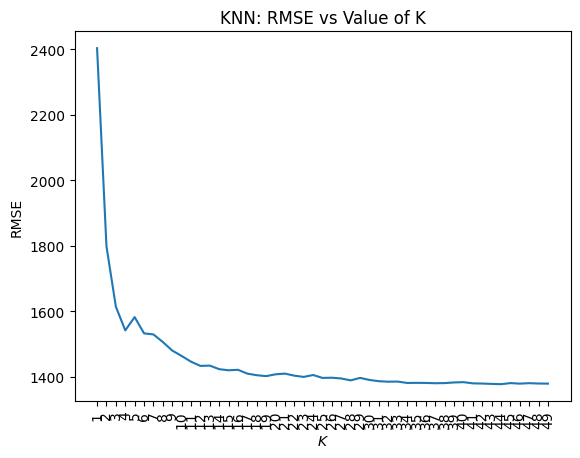

{(19, 1401.7), (35, 1381.16), (31, 1386.21), (6, 1532.47), (30, 1390.08), (16, 1421.11), (39, 1382.4), (36, 1380.95), (20, 1407.28), (17, 1409.37), (33, 1385.11), (7, 1529.16), (29, 1396.34), (45, 1380.4), (46, 1378.82), (49, 1378.86), (28, 1388.77), (44, 1377.16), (4, 1541.61), (9, 1479.97), (24, 1405.18), (15, 1419.58), (1, 2403.98), (34, 1380.92), (10, 1463.41), (18, 1404.57), (37, 1380.03), (48, 1379.14), (25, 1396.26), (13, 1433.92), (21, 1409.45), (38, 1380.42), (42, 1379.05), (43, 1377.98), (27, 1394.52), (26, 1396.92), (47, 1380.21), (23, 1399.37), (40, 1383.31), (5, 1582.12), (8, 1506.04), (12, 1432.98), (11, 1445.96), (22, 1403.13), (2, 1798.36), (41, 1379.66), (3, 1614.01), (14, 1423.0), (32, 1384.74)}


In [13]:
plt.plot(k_range, scores_r)
plt.title('KNN: RMSE vs Value of K')
plt.xlabel(r'$K$')
plt.ylabel('RMSE')
plt.xticks(k_range, rotation=90)
plt.show()

print(set(zip(k_range, scores_r)))

In [14]:
from sklearn import svm

support = svm.SVR()
support.fit(x_train, y_train)
y_pred_svm = support.predict(x_test)

print(RMSE(y_pred_svm, y_test))

dump(support, 'models/svm')

1416.9601431351307


['models/svm']

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor

r1 = DecisionTreeRegressor(criterion='squared_error', splitter='best', random_state=0)
r2 = KNeighborsRegressor(n_neighbors=30)
r3 = svm.SVR()

er = VotingRegressor([('dt', r1), ('kn', r2), ('sv', r3)])

er.fit(x_train, y_train)

y_pred = er.predict(x_test)

print(RMSE(y_pred, y_test))

1453.8825127199061


In [9]:
xt = x[:20]

r1.fit(x, y)
r2.fit(x, y)
r3.fit(x, y)

pred1 = r1.predict(xt)
pred2 = r2.predict(xt)
pred3 = r3.predict(xt)
pred4 = er.predict(xt)

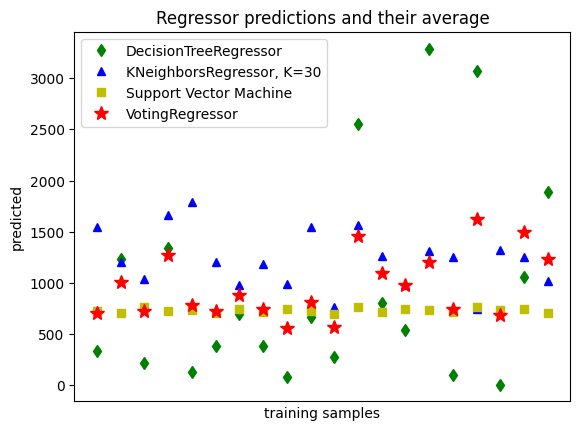

In [10]:
plt.figure()
plt.plot(pred1, "gd", label="DecisionTreeRegressor")
plt.plot(pred2, "b^", label="KNeighborsRegressor, K=30")
plt.plot(pred3, "ys", label="Support Vector Machine")
plt.plot(pred4, "r*", ms=10, label="VotingRegressor")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()

In [11]:
dump(er, 'models/voting_regressor')

['models/voting_regressor']